# Low Rank Tensor Fusion Model - CMU-MOSI

In [ ]:
!git clone https://github.com/M-Jafarkhani/Multimodal-Emotion-Recognition

In [3]:
import gdown

file_id = "1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU"
destination = "mosi_raw.pkl"

gdown.download(
    f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU
From (redirected): https://drive.google.com/uc?id=1szKIqO0t3Be_W91xvf6aYmsVVUa7wDHU&confirm=t&uuid=2e2bb414-f79b-4a28-9b27-6950ee78a289
To: /content/mosi_raw.pkl
100%|██████████| 357M/357M [00:01<00:00, 230MB/s]


'mosi_raw.pkl'

## Importing Libraries

In [4]:
import sys
import torch
import matplotlib.pyplot as plt

sys.path.append('/content/Multimodal-Emotion-Recognition/src')

## Importing Helper Functions

In [5]:
from loader import get_dataloader
from unimodals.modules import GRUWithLinear, MLP
from fusions.modules import LowRankTensorFusion
from training.supervised import train, test
from utils import get_default_device, save_results

## Loading the Dataset

In [6]:
train_data, valid_data, test_data = get_dataloader('/content/mosi_raw.pkl')

In [7]:
device = get_default_device()
print(device)

cuda


## Model Architecture

In [8]:
encoders = [
    GRUWithLinear(35, 64, 32, dropout=True, has_padding=True).to(device),
    GRUWithLinear(74, 128, 32, dropout=True, has_padding=True).to(device),
    GRUWithLinear(300, 512, 128, dropout=True, has_padding=True).to(device)
]

head = MLP(128, 512, 1).to(device)

fusion = LowRankTensorFusion([32, 32, 128], 128, 32).to(device)

/content/Multimodal-Emotion-Recognition/src/fusions/modules.py:303: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  nn.init.xavier_normal(factor)
/content/Multimodal-Emotion-Recognition/src/fusions/modules.py:310: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  nn.init.xavier_normal(self.fusion_weights)


## Training

In [10]:
OUTPUT_MODEL_FILE_NAME = "MOSI_Low_Rank_Tensor_Fusion"
train_losses, valid_losses = train(
    encoders,
    fusion,
    head,
    train_data,
    valid_data,
    100,
    task="regression",
    optimtype=torch.optim.AdamW,
    early_stop=False,
    is_packed=True,
    lr=1e-3,
    save=f"/content/{OUTPUT_MODEL_FILE_NAME}.pt",
    weight_decay=0.01,
    objective=torch.nn.L1Loss(),
)


Epoch [1/100]
Train Loss: 0.3693
Valid Loss: 0.9612
Saving Best

Epoch [2/100]
Train Loss: 0.3432
Valid Loss: 0.9675

Epoch [3/100]
Train Loss: 0.3194
Valid Loss: 0.9583
Saving Best

Epoch [4/100]
Train Loss: 0.2997
Valid Loss: 0.9544
Saving Best

Epoch [5/100]
Train Loss: 0.3023
Valid Loss: 0.9626

Epoch [6/100]
Train Loss: 0.2797
Valid Loss: 0.9436
Saving Best

Epoch [7/100]
Train Loss: 0.2758
Valid Loss: 0.9444

Epoch [8/100]
Train Loss: 0.2680
Valid Loss: 0.9336
Saving Best

Epoch [9/100]
Train Loss: 0.2587
Valid Loss: 0.9578

Epoch [10/100]
Train Loss: 0.2508
Valid Loss: 0.9331
Saving Best

Epoch [11/100]
Train Loss: 0.2478
Valid Loss: 0.9363

Epoch [12/100]
Train Loss: 0.2312
Valid Loss: 0.9452

Epoch [13/100]
Train Loss: 0.2464
Valid Loss: 0.9507

Epoch [14/100]
Train Loss: 0.2239
Valid Loss: 0.9473

Epoch [15/100]
Train Loss: 0.2161
Valid Loss: 0.9463

Epoch [16/100]
Train Loss: 0.2215
Valid Loss: 0.9322
Saving Best

Epoch [17/100]
Train Loss: 0.2021
Valid Loss: 0.9374

Epoch [

Text(0.5, 1.0, 'Loss vs. No. of epochs')

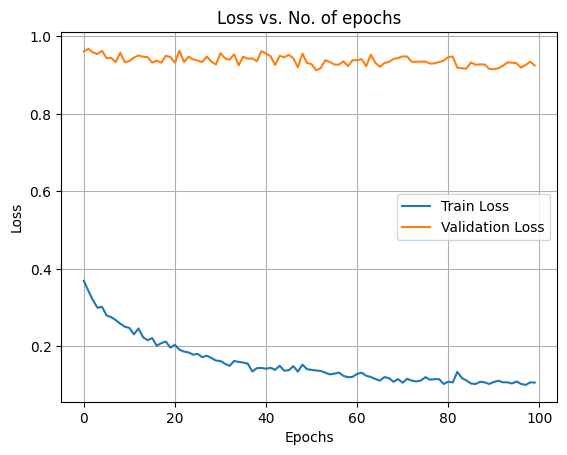

In [11]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [12]:
save_results(train_losses, valid_losses, f'/content/{OUTPUT_MODEL_FILE_NAME}.pkl')

## Testing

In [13]:
model = torch.load(f"/content/{OUTPUT_MODEL_FILE_NAME}.pt").to(device)

test(
    model,
    test_dataloaders_all=test_data,
    is_packed=True,
    criterion=torch.nn.L1Loss(),
    task="posneg-classification"
)


<ipython-input-13-e459be6cf0a0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"/content/{OUTPUT_MODEL_FILE_NAME}.pt").to(device)


Recall: 72.8659% | Total Accuracy: 72.0117%
Inference Time: 325ms
Inference Params: 1486465
